# TER Picopatt - NoZERO

Importation des librairies principales et définition des dossiers de travail.

Nos fonctions utilisées pour lire les données sont dans le fichier `functions.py`

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import functions as fc

#  Dossiers de données et de sortie 
DATA_DIR = Path("/Users/akkouh/Desktop/dataproc")  # là où sont tes fichiers bruts
OUTPUT_DIR = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs")
FIG_DIR = OUTPUT_DIR / "figures"

#  Création automatique des dossiers
fc.create_folder(OUTPUT_DIR)
fc.create_folder(FIG_DIR)

# Vérification
print(" Environnement prêt :")
print(f"DATA_DIR   → {DATA_DIR}")
print(f" OUTPUT_DIR → {OUTPUT_DIR}")
print(f" FIG_DIR    → {FIG_DIR}")


pd.set_option("display.max_columns", 200)

 Environnement prêt :
DATA_DIR   → /Users/akkouh/Desktop/dataproc
 OUTPUT_DIR → /Users/akkouh/Desktop/TER-Picopatt/outputs
 FIG_DIR    → /Users/akkouh/Desktop/TER-Picopatt/outputs/figures


Lecture de tous les fichiers de données (.csv, .xlsx) du dossier `dataproc` dans un seul tableau, nettoyage des colonnes, puis vérification de la couverture temporelle et la répartition des mesures et ajout des colonnes `M_slot` (créneau horaire) et `date`.

In [2]:
# Affichage 
raw = fc.load_all(DATA_DIR, False)

# Résumé
print("Chargement terminé.")
print("Couverture :", raw['date'].min(), "->", raw['date'].max())
print("Parcours :", raw['track_id'].dropna().unique())
print("\nNombre de mesures par M_slot et parcours :")
print(
    raw.pivot_table(index="track_id", columns="M_slot", values="fichier_originaire", aggfunc="count")
       .fillna(0)
       .astype(int)
)
raw.rename(columns={"__source_file": "fichier_originaire"}, inplace=True)

Chargement terminé.
Couverture : 2024-10-29 -> 2025-01-16
Parcours : ['antigone' 'boulevards' 'ecusson']

Nombre de mesures par M_slot et parcours :
M_slot         M1     M2     M3     M4
track_id                              
antigone    29468  29924  29510  30237
boulevards  25603  32084  25785  29980
ecusson     27753  27041  26656  19730


Les données couvrent du `29 octobre au 16 janvier` soit environ 3 mois.

On a trois parcours de collecte : `Antigone, Boulevards et Écusson`.

On observe également `quatre passages par jour` (matin, midi, après-midi et soir), presque `tout les mardis et jeudis`.

# Analyse du pourcentage de valeurs nulles

L’objectif est de repérer les potentiels `capteurs défectueux` et `données anormales` susceptibles de fausser les analyses. 


In [3]:
numerical_cols = raw.select_dtypes(include=np.number).columns.tolist()
zero_percentages_global = {}

for col in numerical_cols:
    total_non_missing = raw[col].count()
    if total_non_missing > 0:
        zero_count = (raw[col] == 0).sum()
        zero_percentage = (zero_count / total_non_missing) * 100
        zero_percentages_global[col] = zero_percentage
    else:
        zero_percentages_global[col] = np.nan

df_zero = pd.DataFrame.from_dict(zero_percentages_global, orient="index", columns=["pct_zero"])
df_zero = df_zero.sort_values("pct_zero", ascending=False).round(3)

print("Pourcentage de valeurs égales à 0 par variable numérique :")
display(df_zero)

Pourcentage de valeurs égales à 0 par variable numérique :


,pct_zero
sw_down,76.259
sw_left,49.748
sw_up,26.567
ws,4.182
sw_back,1.198
tair_tc2,0.603
wdir,0.546
sw_right,0.000
sw_front,0.000
section_id,0.000


L’analyse montre que certaines variables présentent un taux élevé de valeurs nulles.  

- `sw_down` (76.15%), `sw_left` (49.38%) et `sw_up` (26.01%) affichent de fortes proportions de zéros, ce qui peut indiquer des capteurs défaillants ou non activés sur certaines périodes. 
 
- Les autres variables, comme `ws` (4.11%), `sw_back` (1.17%), `tair_tc2` (0.59%) présentent un faible taux de zéros, donc peu préoccupant.  

- Cas particulier : `wdir` (0.55%) qui n'est pas une variable numérique comme les autres. Elle permet de connaitre la direction du vent. Cette variable n'a pas besoin de traitement particulier pour ces valeurs nulles.

- Les mesures des autres variables sont complètes (0%), ce qui confirme une bonne qualité globale des données.  

Ces résultats permettent de cibler les capteurs problématiques à corriger ou à exclure lors de l’analyse suivante.  

In [89]:
results = []

for track_id, df_track in raw.groupby("track_id"):
    for col in numerical_cols:
        total_non_missing = df_track[col].count()
        if total_non_missing > 0:
            zero_count = (df_track[col] == 0).sum()
            zero_percentage = (zero_count / total_non_missing) * 100
        else:
            zero_percentage = np.nan
        results.append({
            "track_id": track_id,
            "variable": col,
            "pct_zero": round(zero_percentage, 3)
        })

df_zero_track = pd.DataFrame(results)
df_zero_track = df_zero_track.sort_values(["track_id", "pct_zero"], ascending=[True, False])

for track_id in df_zero_track["track_id"].unique():
    print(f"\nPourcentage de zéros pour le parcours : {track_id}")
    display(df_zero_track[df_zero_track["track_id"] == track_id].head(10))


Pourcentage de zéros pour le parcours : antigone


,track_id,variable,pct_zero
20,antigone,sw_down,65.085
23,antigone,sw_left,34.186
19,antigone,sw_up,26.739
17,antigone,ws,2.830
22,antigone,sw_back,2.792
18,antigone,wdir,0.310
24,antigone,sw_right,0.001
0,antigone,section_id,0.000
1,antigone,segment_id,0.000
2,antigone,point_id,0.000



Pourcentage de zéros pour le parcours : boulevards


,track_id,variable,pct_zero
53,boulevards,sw_down,76.006
56,boulevards,sw_left,51.475
52,boulevards,sw_up,27.705
50,boulevards,ws,5.115
51,boulevards,wdir,0.667
33,boulevards,section_id,0.000
34,boulevards,segment_id,0.000
35,boulevards,point_id,0.000
36,boulevards,section_duration,0.000
37,boulevards,section_speed,0.000



Pourcentage de zéros pour le parcours : ecusson


,track_id,variable,pct_zero
86,ecusson,sw_down,89.700
89,ecusson,sw_left,66.136
85,ecusson,sw_up,25.088
83,ecusson,ws,4.726
80,ecusson,tair_tc2,1.988
84,ecusson,wdir,0.687
88,ecusson,sw_back,0.666
66,ecusson,section_id,0.000
67,ecusson,segment_id,0.000
68,ecusson,point_id,0.000


On observe quelques variations notamment pour le parcours `Écusson` où le nombre de valeurs nulles explose pour les variables `sw_down` et `sw_left`

Deux variables ont un pourcentage trop élevé sur l'ensemble des données, `sw_down` et `sw_left`.

Nous pouvons pas les garder pour la suite des calculs, au risque de biaiser nos résultats

In [90]:
raw = raw.drop(columns=['sw_down','sw_left'], errors='ignore') 

In [91]:
#  Fonction d'analyse des zéros par parcours 
def zeros_report_for_track(raw: pd.DataFrame, track_name: str, cols=None) -> pd.DataFrame:
    sub = raw.loc[raw["track_id"].astype(str).str.strip().str.lower() == track_name.lower()].copy()
    if sub.empty:
        print(f" Aucun enregistrement trouvé pour {track_name}")
        return pd.DataFrame()

    # Index local dans le fichier source
    if "__row_in_file" not in sub.columns:
        sub["__row_in_file"] = sub.groupby("fichier_originaire").cumcount()

    # Création de la colonne date si manquante
    if "date" not in sub.columns and "timestamp" in sub.columns:
        sub["date"] = pd.to_datetime(sub["timestamp"], errors="coerce").dt.date

    # Colonnes numériques à examiner
    if cols is None:
        exclude = {
            "point_id","segment_id","section_id","track_id","project_id",
            "timestamp","date","M_slot","passage_slot","fichier_originaire",
            "lon","lat","lon_rtk","lat_rtk","lon_ontrack","lat_ontrack",
            "__row_in_file"
        }
        cols = [c for c in sub.select_dtypes(include=[np.number]).columns if c not in exclude]
    else:
        cols = [c for c in cols if c in sub.columns]

    if not cols:
        print(f"Aucune colonne numérique à analyser pour {track_name}")
        return pd.DataFrame()

    # Détection des zéros
    is_zero = (sub[cols] == 0)
    long = (
        is_zero.stack()
        .rename("is_zero")
        .reset_index()
        .query("is_zero")
        .rename(columns={"level_1": "variable"})
        .drop(columns=["is_zero"])
    )

    meta_cols = [c for c in ["timestamp", "date", "track_id", "fichier_originaire", "__row_in_file"] if c in sub.columns]
    out = long.merge(sub[meta_cols], left_on="level_0", right_index=True, how="left").drop(columns=["level_0"])

    wanted = ["track_id", "variable", "timestamp", "date", "fichier_originaire", "__row_in_file"]
    out = out[[c for c in wanted if c in out.columns]].sort_values(["fichier_originaire", "__row_in_file", "variable"]).reset_index(drop=True)
    return out

In [92]:
VZERO = OUTPUT_DIR / "visu_zeros"
fc.create_folder(VZERO)

tracks = ["antigone", "ecusson", "boulevards"]
reports = {}

for t in tracks:
    rep = zeros_report_for_track(raw, t)
    reports[t] = rep
    out_csv = VZERO / f"zeros_{t}.csv"
    rep.to_csv(out_csv, index=False)
    print(f"Export zéros {t} -> {out_csv.name} ({len(rep)} lignes)")

    if not rep.empty:
        counts = (
            rep.groupby(["fichier_originaire", "variable"])
            .size()
            .reset_index(name="n_zero")
            .sort_values(["fichier_originaire", "n_zero"], ascending=[True, False])
        )
        print(f"\nRésumé des zéros pour {t}:")
        display(counts.head(15))

Export zéros antigone -> zeros_antigone.csv (38924 lignes)

Résumé des zéros pour antigone:


,fichier_originaire,variable,n_zero
3,picopatt_montpellier_antigone_20241029_0835.csv,ws,122
0,picopatt_montpellier_antigone_20241029_0835.csv,sw_back,19
2,picopatt_montpellier_antigone_20241029_0835.csv,wdir,4
1,picopatt_montpellier_antigone_20241029_0835.csv,sw_up,3
5,picopatt_montpellier_antigone_20241029_1127.csv,ws,100
4,picopatt_montpellier_antigone_20241029_1127.csv,wdir,12
7,picopatt_montpellier_antigone_20241029_1423.csv,ws,107
6,picopatt_montpellier_antigone_20241029_1423.csv,wdir,1
9,picopatt_montpellier_antigone_20241029_1722.csv,sw_up,4390
8,picopatt_montpellier_antigone_20241029_1722.csv,sw_back,1543


Export zéros ecusson -> zeros_ecusson.csv (33546 lignes)

Résumé des zéros pour ecusson:


,fichier_originaire,variable,n_zero
3,picopatt_montpellier_ecusson_20241031_0827.csv,ws,267
1,picopatt_montpellier_ecusson_20241031_0827.csv,sw_up,57
2,picopatt_montpellier_ecusson_20241031_0827.csv,wdir,26
0,picopatt_montpellier_ecusson_20241031_0827.csv,sw_back,9
5,picopatt_montpellier_ecusson_20241031_1127.csv,ws,251
4,picopatt_montpellier_ecusson_20241031_1127.csv,wdir,27
6,picopatt_montpellier_ecusson_20241031_1425.csv,sw_up,611
8,picopatt_montpellier_ecusson_20241031_1425.csv,ws,197
7,picopatt_montpellier_ecusson_20241031_1425.csv,wdir,9
9,picopatt_montpellier_ecusson_20241112_0830.csv,sw_up,416


Export zéros boulevards -> zeros_boulevards.csv (37992 lignes)

Résumé des zéros pour boulevards:


,fichier_originaire,variable,n_zero
2,picopatt_montpellier_boulevards_20241114_0828.csv,ws,226
0,picopatt_montpellier_boulevards_20241114_0828.csv,sw_up,51
1,picopatt_montpellier_boulevards_20241114_0828.csv,wdir,49
4,picopatt_montpellier_boulevards_20241114_1121.csv,ws,116
3,picopatt_montpellier_boulevards_20241114_1121.csv,wdir,91
7,picopatt_montpellier_boulevards_20241114_1429.csv,ws,164
5,picopatt_montpellier_boulevards_20241114_1429.csv,sw_up,78
6,picopatt_montpellier_boulevards_20241114_1429.csv,wdir,76
8,picopatt_montpellier_boulevards_20241114_1728.csv,sw_up,4119
10,picopatt_montpellier_boulevards_20241114_1728.csv,ws,135


In [93]:
def zeros_intervals_for_track(raw: pd.DataFrame, track_name: str, cols=None, min_len: int = 1) -> pd.DataFrame:
    """Détecte les intervalles de zéros consécutifs pour un parcours donné."""
    sub = raw.loc[raw["track_id"].astype(str).str.strip().str.lower() == track_name.lower()].copy()
    if sub.empty:
        print(f" Aucun enregistrement pour {track_name}")
        return pd.DataFrame()

    if "__row_in_file" not in sub.columns:
        sub["__row_in_file"] = sub.groupby("fichier_originaire").cumcount()

    if cols is None:
        exclude = {
            "point_id","segment_id","section_id","track_id","project_id",
            "timestamp","date","M_slot","passage_slot","fichier_originaire",
            "lon","lat","lon_rtk","lat_rtk","lon_ontrack","lat_ontrack","__row_in_file"
        }
        cols = [c for c in sub.select_dtypes(include=[np.number]).columns if c not in exclude]
    else:
        cols = [c for c in cols if c in sub.columns]
    if not cols:
        print(f" Aucune variable numérique à analyser pour {track_name}")
        return pd.DataFrame()

    out_rows = []
    for src, chunk in sub.groupby("fichier_originaire", sort=False):
        sort_keys = [c for c in ("timestamp", "__row_in_file") if c in chunk.columns]
        if sort_keys:
            chunk = chunk.sort_values(sort_keys, kind="stable")

        for var in cols:
            mask = (chunk[var] == 0)
            if not mask.any():
                continue
            run_id = (mask != mask.shift(fill_value=False)).cumsum()
            for _, g in chunk.loc[mask].groupby(run_id[mask]):
                n = len(g)
                if n < min_len:
                    continue
                out_rows.append({
                    "track_id": track_name,
                    "variable": var,
                    "fichier_originaire": src,
                    "start_row_in_file": int(g["__row_in_file"].iloc[0]),
                    "end_row_in_file": int(g["__row_in_file"].iloc[-1]),
                    "n_rows": int(n),
                    "start_timestamp": g["timestamp"].iloc[0] if "timestamp" in g else None,
                    "end_timestamp": g["timestamp"].iloc[-1] if "timestamp" in g else None,
                })

    out = pd.DataFrame(out_rows)
    if not out.empty:
        out = out.sort_values(["fichier_originaire","variable","start_row_in_file"]).reset_index(drop=True)
    return out

In [94]:
# Variables à traiter uniquement
VARS_TO_IMPUTE = ("sw_up","sw_back","tair_tc2","ws","sw_right")
MAX_RUN = 30

def _replace_zero_runs_with_endpoints_mean(s: pd.Series, max_run: int = 30) -> pd.Series:
    """
    Remplace les runs de 0 par la moyenne (valeur[i0-1] + valeur[i1+1]) / 2
    si et seulement si:
      - longueur du run <= max_run
      - les deux extrémités existent et ne sont pas NaN
    Sinon, met NaN sur tout le run.

    s doit être numérique; les NaN sont propagés.
    """
    x = pd.to_numeric(s, errors="coerce").copy()
    v = x.values
    n = len(v)
    if n == 0:
        return x

    mask = (v == 0)
    if not mask.any():
        return x

    # détecter starts/ends de runs True dans mask
    # start: position True avec précédent False (ou début)
    # end  : position True avec suivant False (ou fin)
    prev = np.pad(mask[:-1], (1,0), constant_values=False)
    next_ = np.pad(mask[1:],  (0,1), constant_values=False)
    starts = np.where(mask & ~prev)[0]
    ends   = np.where(mask & ~next_)[0]

    for i0, i1 in zip(starts, ends):
        run_len = i1 - i0 + 1
        if run_len <= max_run and i0 > 0 and i1 < n - 1:
            left  = v[i0 - 1]
            right = v[i1 + 1]
            if np.isfinite(left) and np.isfinite(right):
                fill_val = (left + right) / 2.0
                v[i0:i1+1] = fill_val
            else:
                v[i0:i1+1] = np.nan
        else:
            # trop long, ou bord du fichier, ou extrémité manquante/non numérique
            v[i0:i1+1] = np.nan

    return pd.Series(v, index=x.index)

In [95]:
# Dossier de sortie des fichiers nettoyés
CLEAN_DIR = OUTPUT_DIR / "clean_nozeros"
fc.create_folder(CLEAN_DIR)

def nozero(df_file: pd.DataFrame,
                       vars_to_impute=VARS_TO_IMPUTE,
                       max_run: int = MAX_RUN) -> tuple[pd.DataFrame, list[dict]]:
    """
    Applique l'imputation "moyenne des voisins" sur les colonnes cibles d'un fichier.
    Retourne :
      - le DataFrame transformé
      - un résumé détaillé des remplacements effectués
    """
    df_out = df_file.copy()
    summary = []

    # Tri par timestamp ou index interne
    sort_keys = [c for c in ("timestamp", "__row_in_file") if c in df_out.columns]
    if sort_keys:
        df_out = df_out.sort_values(sort_keys, kind="stable")

    for col in vars_to_impute:
        # Si la colonne n'existe pas dans ce fichier
        if col not in df_out.columns:
            summary.append({
                "fichier_originaire": df_out["fichier_originaire"].iloc[0],
                "variable": col,
                "nb_zero_avant_traitement": 0,
                "nb_intervals_replaced": 0,
                "nb_intervals_replaced_nan": 0,
                "nb_points_replaced": 0,
                "nb_points_replaced_nan": 0,
                "index_replaced": [],
                "index_replaced_nan": [],
                "note": "colonne absente"
            })
            continue

        # Conversion en numérique
        df_out[col] = pd.to_numeric(df_out[col], errors="coerce")

        # Comptage des zéros avant correction
        mask_zero = (df_out[col] == 0)
        nb_zero_avant_traitement = int(mask_zero.sum())

        # Application de l’imputation
        col_before = df_out[col].copy()
        col_after = _replace_zero_runs_with_endpoints_mean(col_before, max_run=max_run)
        df_out[col] = col_after

        # Détection des runs
        mask0 = (col_before.values == 0)
        prev = np.pad(mask0[:-1], (1, 0), constant_values=False)
        next_ = np.pad(mask0[1:], (0, 1), constant_values=False)
        starts = np.where(mask0 & ~prev)[0]
        ends = np.where(mask0 & ~next_)[0]

        nb_intervals_replaced = 0
        nb_intervals_replaced_nan = 0
        nb_points_replaced = 0
        nb_points_replaced_nan = 0
        index_replaced = []
        index_replaced_nan = []

        for i0, i1 in zip(starts, ends):
            run_len = i1 - i0 + 1
            block_after = col_after.iloc[i0:i1+1]
            run_str = str(i0) if run_len == 1 else f"{i0}-{i1}"

            if block_after.notna().all():
                nb_intervals_replaced += 1
                nb_points_replaced += run_len
                index_replaced.append(run_str)

            else:
                nb_intervals_replaced_nan += 1
                nb_points_replaced_nan += run_len
                index_replaced_nan.append(run_str)


        summary.append({
            "fichier_originaire": df_out["fichier_originaire"].iloc[0],
            "variable": col,
            "nb_zero_avant_traitement": int(nb_zero_avant_traitement),
            "nb_points_replaced": int(nb_points_replaced),
            "nb_points_replaced_nan": int(nb_points_replaced_nan),
            "index_replaced": index_replaced,
            "index_replaced_nan": index_replaced_nan
        })

    return df_out, summary

In [96]:
# Boucle globale : traitement de tous les fichiers
all_summ = []

for src, df_file in raw.groupby("fichier_originaire", sort=False):
    #  Nettoyage et imputation des zéros
    df_clean, summ = nozero(df_file, vars_to_impute=VARS_TO_IMPUTE, max_run=MAX_RUN)
    all_summ.extend(summ)

    #  Attribution du M_slot (pour l’hiver)
    mslot = fc.assign_mslot_from_filename_winter(src)
    df_clean["M_slot"] = mslot

    # Sauvegarde
    out_path = CLEAN_DIR / src
    df_clean.to_csv(out_path, index=False)

print("Fichiers sont mis à jour")

# Export du résumé global
summary_df = pd.DataFrame(all_summ)
summary_path = VZERO / "imputation_summary.csv"
summary_df.to_csv(summary_path, index=False)

#  Synthèse rapide
print(f"\nFichiers nettoyés écrits dans : {CLEAN_DIR}")
print(f" Résumé global : {summary_path}\n")

display(summary_df.head(20))

# Vue d'ensemble par variable
print("Résumé global des imputations par variable :")
print(summary_df.groupby("variable")[["nb_zero_avant_traitement","nb_points_replaced", "nb_points_replaced_nan"]].sum())

Fichiers sont mis à jour

Fichiers nettoyés écrits dans : /Users/akkouh/Desktop/TER-Picopatt/outputs/clean_nozeros
 Résumé global : /Users/akkouh/Desktop/TER-Picopatt/outputs/visu_zeros/imputation_summary.csv



,fichier_originaire,variable,nb_zero_avant_traitement,nb_points_replaced,nb_points_replaced_nan,index_replaced,index_replaced_nan
0,picopatt_montpellier_antigone_20241029_0835.csv,sw_up,3,3,0,"[71, 74, 111]",[]
1,picopatt_montpellier_antigone_20241029_0835.csv,sw_back,19,19,0,"[71, 73-74, 92, 106, 111, 135, 223, 346, 361, ...",[]
2,picopatt_montpellier_antigone_20241029_0835.csv,tair_tc2,0,0,0,[],[]
3,picopatt_montpellier_antigone_20241029_0835.csv,ws,122,122,0,"[186, 479-486, 498, 505-506, 508-512, 515-517,...",[]
4,picopatt_montpellier_antigone_20241029_0835.csv,sw_right,0,0,0,[],[]
5,picopatt_montpellier_antigone_20241029_1127.csv,sw_up,0,0,0,[],[]
6,picopatt_montpellier_antigone_20241029_1127.csv,sw_back,0,0,0,[],[]
7,picopatt_montpellier_antigone_20241029_1127.csv,tair_tc2,0,0,0,[],[]
8,picopatt_montpellier_antigone_20241029_1127.csv,ws,100,100,0,"[574-579, 585-589, 768, 817-818, 820-825, 833,...",[]
9,picopatt_montpellier_antigone_20241029_1127.csv,sw_right,0,0,0,[],[]


Résumé global des imputations par variable :
          nb_zero_avant_traitement  nb_points_replaced  nb_points_replaced_nan
variable                                                                      
sw_back                       4000                2672                    1328
sw_right                         1                   1                       0
sw_up                        88672                2261                   86411
tair_tc2                      2011                   0                    2011
ws                           13957               13663                     294


### Vérification du nettoyage des Zéros

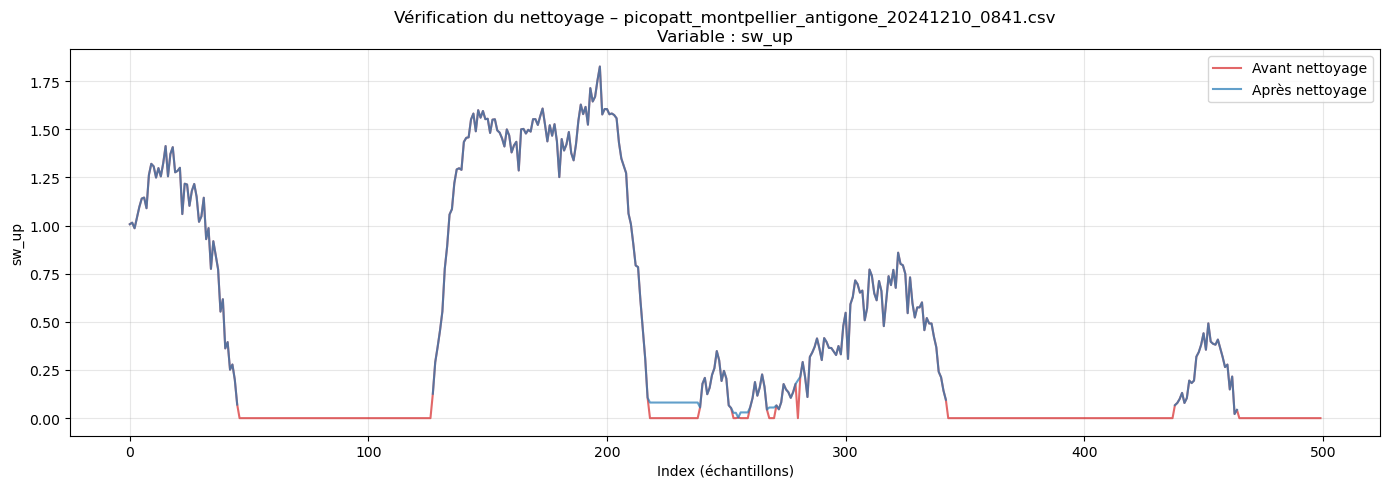

In [97]:
file_to_check = "picopatt_montpellier_antigone_20241210_0841.csv" 
var_to_check = "sw_up" 
n_points = 500  


# Chargement avant/après nettoyage
df_raw_check = raw.loc[raw["fichier_originaire"] == file_to_check].copy()
df_clean_check = pd.read_csv(CLEAN_DIR / file_to_check)

# Vérifications de base
if var_to_check not in df_raw_check.columns:
    print(f" Variable {var_to_check} absente du fichier brut.")
elif var_to_check not in df_clean_check.columns:
    print(f" Variable {var_to_check} absente du fichier nettoyé.")
else:
    # Tri pour garder le bon ordre temporel
    sort_keys = [c for c in ("timestamp", "__row_in_file") if c in df_raw_check.columns]
    if sort_keys:
        df_raw_check = df_raw_check.sort_values(sort_keys)
        df_clean_check = df_clean_check.sort_values(sort_keys)

    # Extraction d’un extrait pour visualisation
    idx_end = min(n_points, len(df_raw_check))
    y_raw = df_raw_check[var_to_check].head(idx_end).to_numpy()
    y_clean = df_clean_check[var_to_check].head(idx_end).to_numpy()

    # Tracé
    plt.figure(figsize=(14, 5))
    plt.plot(y_raw, label="Avant nettoyage", color="tab:red", alpha=0.7)
    plt.plot(y_clean, label="Après nettoyage", color="tab:blue", alpha=0.7)
    plt.title(f"Vérification du nettoyage – {file_to_check}\nVariable : {var_to_check}")
    plt.xlabel("Index (échantillons)")
    plt.ylabel(var_to_check)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [98]:
CLEAN_DIR = OUTPUT_DIR / "clean_nozeros"

# Récupération des fichiers nettoyés
clean_files = sorted(CLEAN_DIR.glob("*.csv"))
assert clean_files, f"Aucun fichier trouvé dans {CLEAN_DIR}"

zero_summary = []

for p in clean_files:
    try:
        df = pd.read_csv(p)
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        numeric_cols = numeric_cols.drop("wdir", errors="ignore")
        if numeric_cols.empty:
            continue

        for col in numeric_cols:
            n_zeros = (df[col] == 0).sum()
            if n_zeros > 0:
                zero_summary.append({
                    "fichier_originaire": p.name,
                    "variable": col,
                    "n_zeros": n_zeros,
                    "pct_zeros": 100 * n_zeros / len(df)
                })
    except Exception as e:
        print(f"Erreur lecture {p.name}: {e}")

# Résumé
zero_summary_df = pd.DataFrame(zero_summary)

if zero_summary_df.empty:
    print("Aucun zéro trouvé dans les fichiers nettoyés.")
else:
    print("Zéros restants détectés dans les fichiers nettoyés :")
    display(
        zero_summary_df.sort_values(["pct_zeros"], ascending=False)
                       .groupby("fichier_originaire")
                       .head(5)
                       .reset_index(drop=True)
    )
    print(f"\nNombre total de fichiers concernés : {zero_summary_df['fichier_originaire'].nunique()}")
    print(f"Nombre total de lignes à zéro restantes : {zero_summary_df['n_zeros'].sum()}")

Aucun zéro trouvé dans les fichiers nettoyés.
